## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

        
cv2.destroyAllWindows()

## Display the Camera Calibration Results

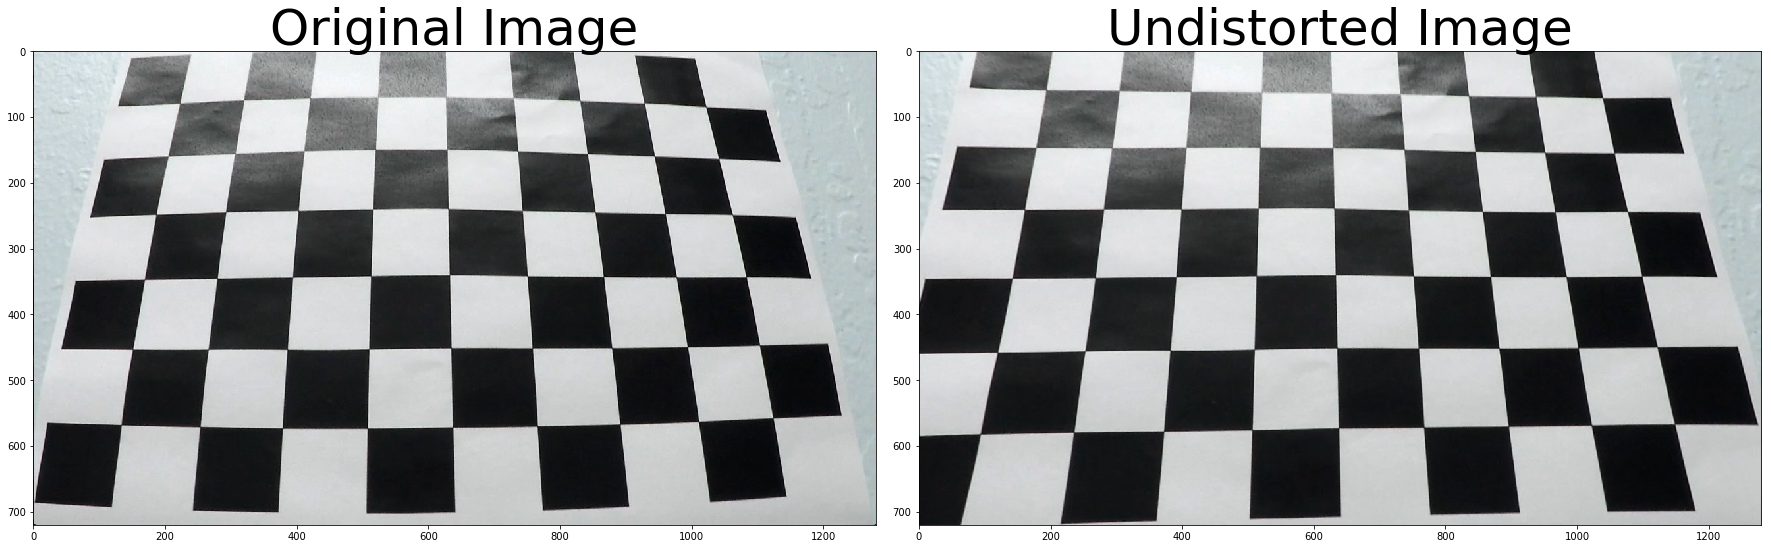

In [3]:
# performs the camera calibration, image distortion correction and returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist


img = cv2.imread(images[13])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
undistorted = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline (Test Images)
### Load Test Image

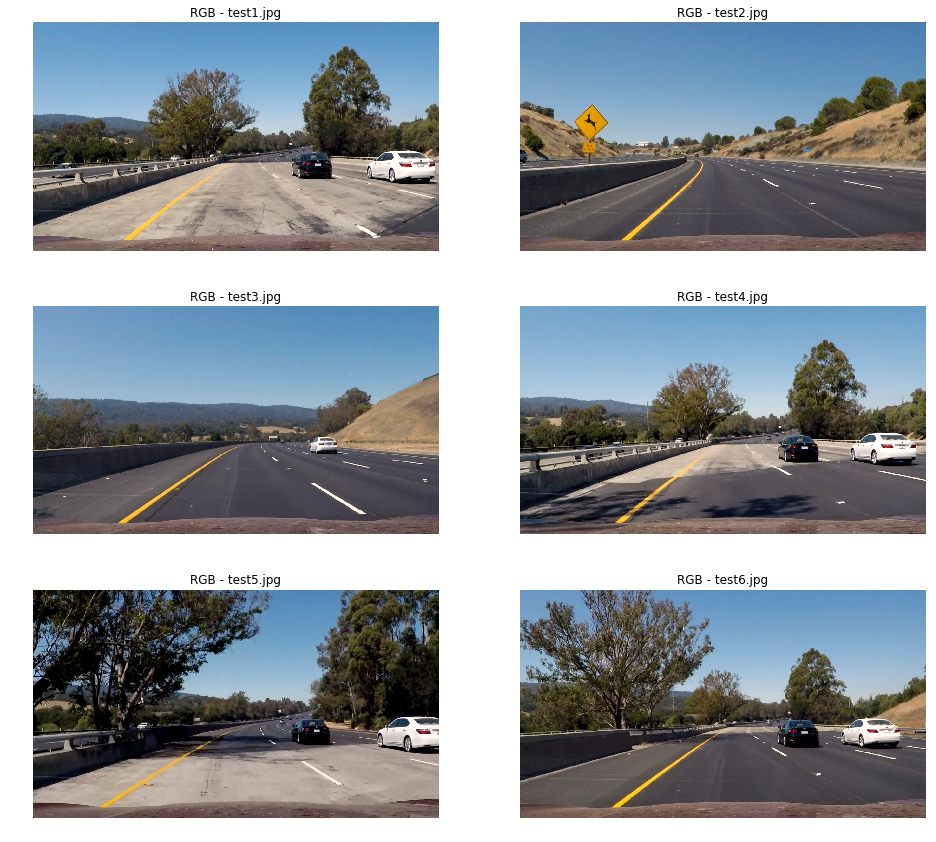

In [39]:
# Make a list of test images
images = glob.glob('./test_images/*.jpg')

def importRGB(imgPath):
    img = cv2.imread(imgPath)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return rgb

plt.figure(figsize=(16,20))
for n in range(2,len(images)):
    img = importRGB(images[n])
    plt.subplot(4,2,n+1)
    plt.axis('off')
    plt.title('RGB - '+images[n].split('\\')[-1])
    imgplot = plt.imshow(img)



### Distortion Correction

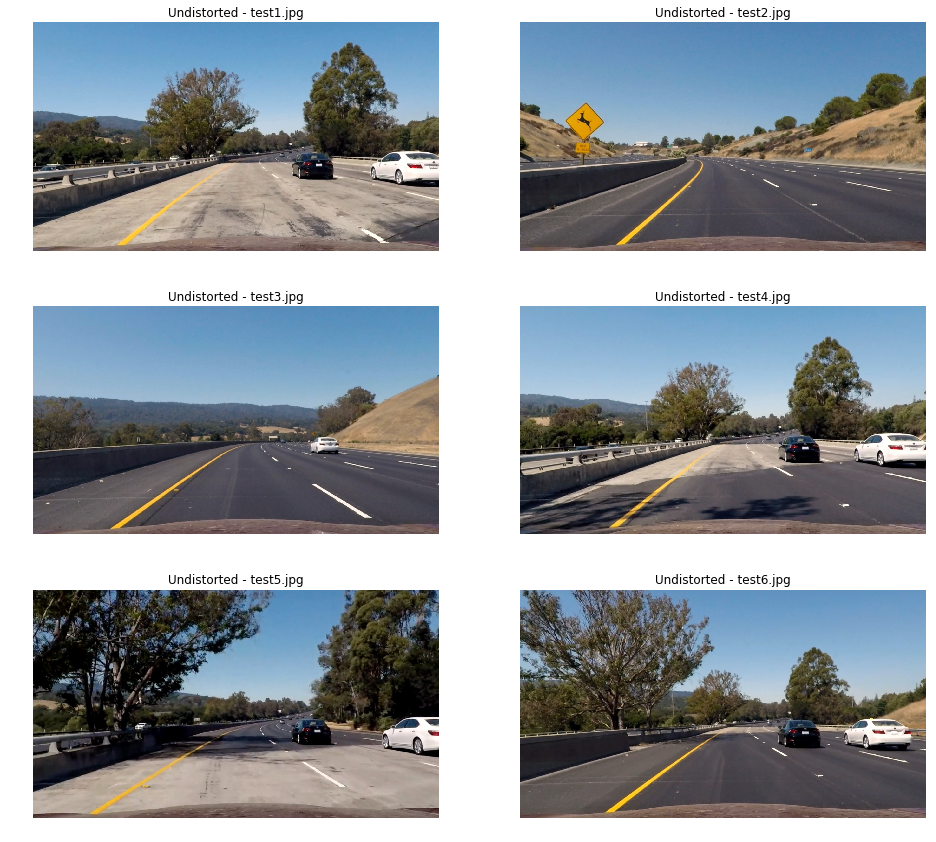

In [38]:
plt.figure(figsize=(16,20))
for n in range(2,len(images)):
    img = importRGB(images[n])
    undistorted = cal_undistort(img, objpoints, imgpoints)

    plt.subplot(4,2,n+1)
    plt.axis('off')
    plt.title('Undistorted - '+images[n].split('\\')[-1])
    imgplot = plt.imshow(undistorted)

### Colour and Gradient

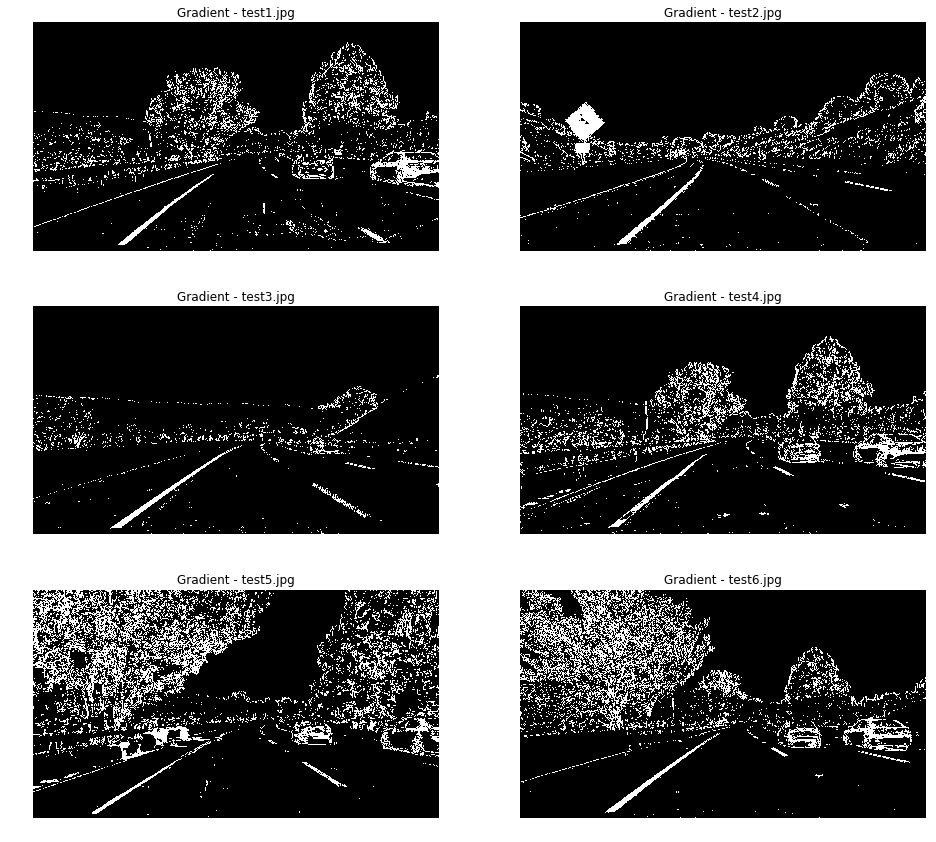

In [244]:
def colgrad(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary > 0))
    color_binary = (sxbinary > 0) | (s_binary > 0)
    # map output to 0-255 as np.uint8 type
    color_binary = (color_binary*255).astype(np.uint8)
    return color_binary
    
plt.figure(figsize=(16,20))
img = importRGB(images[0])
img = cal_undistort(img, objpoints, imgpoints)
img = colgrad(img)

for n in range(2,len(images)):
    img = importRGB(images[n])
    img = cal_undistort(img, objpoints, imgpoints)
    img = colgrad(img)
    
    plt.subplot(4,2,n+1)
    plt.axis('off')
    plt.title('Gradient - '+images[n].split('\\')[-1])
    imgplot = plt.imshow(img, cmap='gray')

### Perspective Transform

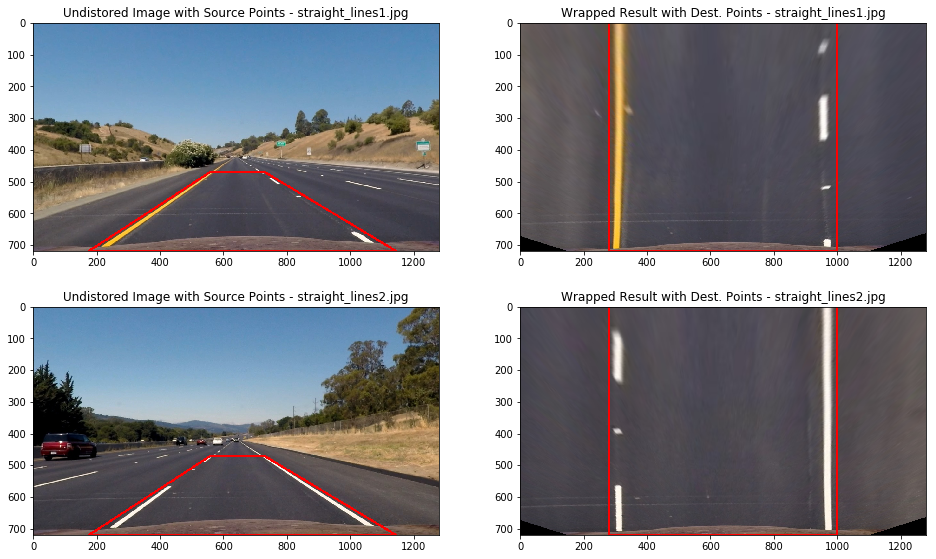

In [238]:
def perspectiveCorrect(img, src, dst):
    M = cv2.getPerspectiveTransform(src,dst)
    img = cv2.warpPerspective(img,M,(1280,720))
    return img

#                  left top right top       bottom  bottom
src = np.float32([[560,470],[728,470],[1145,720],[175,720]])
dst = np.float32([[280,0],[1000,0],[1000,720],[280,720]])

plt.figure(figsize=(16,20))
for n in range(0,2):
    img_rgb = importRGB(images[n])
    img_undistort = cal_undistort(img_rgb, objpoints, imgpoints)
    img_perspective = perspectiveCorrect(img_undistort, src, dst)
    
    plt.subplot(4,2,2*n+1)
    plt.title('Undistored Image with Source Points - '+images[n].split('\\')[-1])
    # overlay source points
    img_src = cv2.polylines(img_undistort,[src.astype(np.int32).reshape((-1,1,2))],True,(255,0,0),5);
    plt.imshow(img_src)

    plt.subplot(4,2,2*n+2)
    plt.title('Wrapped Result with Dest. Points - '+images[n].split('\\')[-1])
    # overlay destination points
    img_dst = cv2.polylines(img_perspective,[dst.astype(np.int32).reshape((-1,1,2))],True,(255,0,0),5)
    plt.imshow(img_dst)
    

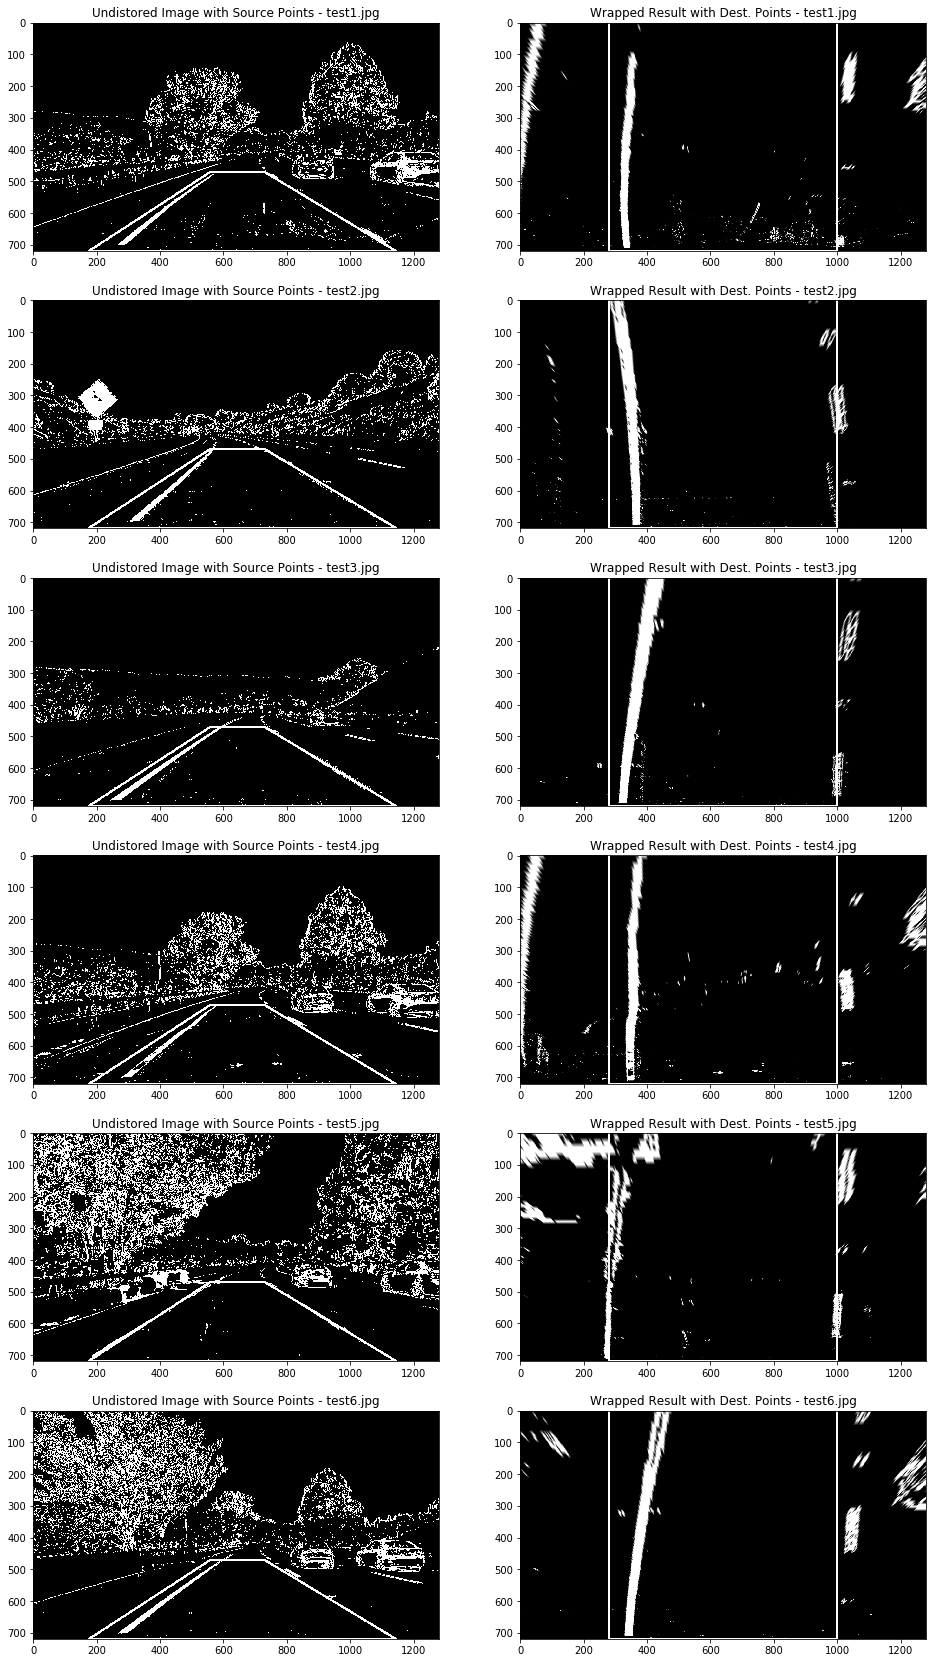

In [251]:
plt.figure(figsize=(16,40))
for n in range(2,len(images)):
    img_rgb = importRGB(images[n])
    img_undistort = cal_undistort(img_rgb, objpoints, imgpoints)
    img_colgrad = colgrad(img_undistort)
    img_perspective = perspectiveCorrect(img_colgrad, src, dst)
    
    plt.subplot(8,2,2*n+1)
    plt.title('Undistored Image with Source Points - '+images[n].split('\\')[-1])
    # overlay source points
    img_src = cv2.polylines(img_colgrad,[src.astype(np.int32).reshape((-1,1,2))],True,(255,0,0),5);
    plt.imshow(img_src,cmap='gray')

    plt.subplot(8,2,2*n+2)
    plt.title('Wrapped Result with Dest. Points - '+images[n].split('\\')[-1])
    # overlay destination points
    img_dst = cv2.polylines(img_perspective,[dst.astype(np.int32).reshape((-1,1,2))],True,(255,0,0),5)
    plt.imshow(img_dst,cmap='gray')